In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
args = {}
args["data_dir"] = "data/segmentation02/segmentation"
args["data"] = "segmentation02loc"
args["lr"] = 0.01
# utils.create_data_file_lists(args["data_dir"])
# utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [3]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"], batch_size=4, num_workers=8
        )

In [4]:
import timm
class UNet(nn.Module):
    def __init__(self, num_classes=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.resnet = timm.create_model(encoder_name, pretrained=True, features_only=False, num_classes=num_classes)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.act(x)
        x = x.view(-1, 2, 4)
        return x

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("cpu")

In [6]:
# model = UNet()
model = UNet(num_classes=8)
loss_fn = nn.MSELoss()
# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [7]:
from torchsummary import summary
summary(model.to(torch.device("cpu")), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
          Identity-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
          Identity-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
       BasicBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14           [-1, 64,

In [8]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [9]:
images, bboxes = next(iter(dataloaders["train"]))
print(images.shape, bboxes.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 2, 4])


In [10]:
bboxes.min(), bboxes.max()

(tensor(0.0508), tensor(0.9727))

In [11]:
def de_normalize_bboxes(bboxes):
    bb = bboxes.clone()
    bb[:, 0::2] *= 256
    bb[:, 1::2] *= 256
    return bb

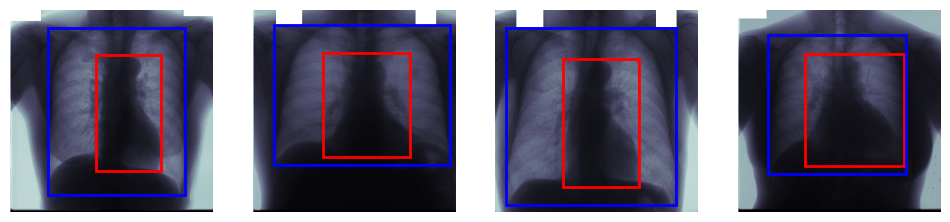

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # Create a 2x2 grid of subplots
for idx, ax in zip(range(4), axs.ravel()):  # Iterate over each subplot
    ax.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
    ax.axis('off')
    # Plot bounding boxes
    edge_colors = ["r", "b"]
    for i, box in enumerate(de_normalize_bboxes(bboxes[idx])):
        min_x, min_y, max_x, max_y = box
        width = max_x - min_x
        height = max_y - min_y
        rect = patches.Rectangle((min_x, min_y), width, height, linewidth=2, edgecolor=edge_colors[i], facecolor='none')
        ax.add_patch(rect)

plt.show()

In [13]:
from tqdm import tqdm

In [14]:
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.repeat(1, 3, 1, 1)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs)
                        # print(outputs.min(), outputs.max())
                        loss = loss_fn(outputs, labels)
                        # print(loss.shape, loss)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 10)

Val Epoch 1/10: 100%|██████████| 5/5 [00:28<00:00,  5.77s/batch]


Epoch 1/10 -> Train Loss: 0.001351, Val Loss: 0.000700


Val Epoch 2/10: 100%|██████████| 5/5 [00:29<00:00,  5.82s/batch]


Epoch 2/10 -> Train Loss: 0.000452, Val Loss: 0.000354


Val Epoch 3/10: 100%|██████████| 5/5 [00:29<00:00,  5.82s/batch]


Epoch 3/10 -> Train Loss: 0.000379, Val Loss: 0.000281


Val Epoch 4/10: 100%|██████████| 5/5 [00:28<00:00,  5.73s/batch]


Epoch 4/10 -> Train Loss: 0.000304, Val Loss: 0.000236


Val Epoch 5/10: 100%|██████████| 5/5 [00:28<00:00,  5.74s/batch]


Epoch 5/10 -> Train Loss: 0.000258, Val Loss: 0.000322


Val Epoch 6/10: 100%|██████████| 5/5 [00:29<00:00,  5.84s/batch]


Epoch 6/10 -> Train Loss: 0.000218, Val Loss: 0.000238


Val Epoch 7/10: 100%|██████████| 5/5 [00:29<00:00,  5.94s/batch]


Epoch 7/10 -> Train Loss: 0.000215, Val Loss: 0.000430


Val Epoch 8/10: 100%|██████████| 5/5 [00:28<00:00,  5.73s/batch]


Epoch 8/10 -> Train Loss: 0.000203, Val Loss: 0.000241


Val Epoch 9/10: 100%|██████████| 5/5 [00:29<00:00,  5.90s/batch]


Epoch 9/10 -> Train Loss: 0.000204, Val Loss: 0.000259


Val Epoch 10/10: 100%|██████████| 5/5 [00:28<00:00,  5.69s/batch]

Epoch 10/10 -> Train Loss: 0.000162, Val Loss: 0.000225


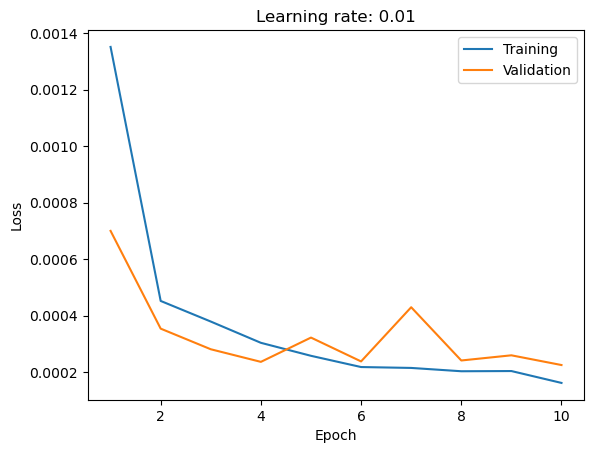

In [15]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [16]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [17]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.repeat(1, 3, 1, 1))
            loss = loss_fn(outputs, labels)
            # loss = torch.mean(channel_weights*loss)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0002


In [27]:
outputs.shape

torch.Size([48, 2, 4])

In [30]:
def calculate_iou(pred_boxes, true_boxes):
    intersection_x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    intersection_y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    intersection_x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    intersection_y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])

    intersection_area = torch.clamp(intersection_x2 - intersection_x1, min=0) * torch.clamp(intersection_y2 - intersection_y1, min=0)

    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    true_area = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])

    union_area = pred_area + true_area - intersection_area

    iou = intersection_area / (union_area + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(iou)
print("mIoU: ", calculate_iou(outputs.view(outputs.shape[0]*outputs.shape[1], 4), targets.view(targets.shape[0]*targets.shape[1], 4)))
for i, mask in zip(range(2),["Heart","Lungs"]):
    print(f"mIoU: {mask}: ", calculate_iou(outputs[:,i,:], targets[:,i,:]).item())

mIoU:  tensor(0.8553)
mIoU: Heart:  0.803549587726593
mIoU: Lungs:  0.9070071578025818


In [20]:
outputs.max(), outputs.min()

(tensor(0.9803), tensor(0.0378))

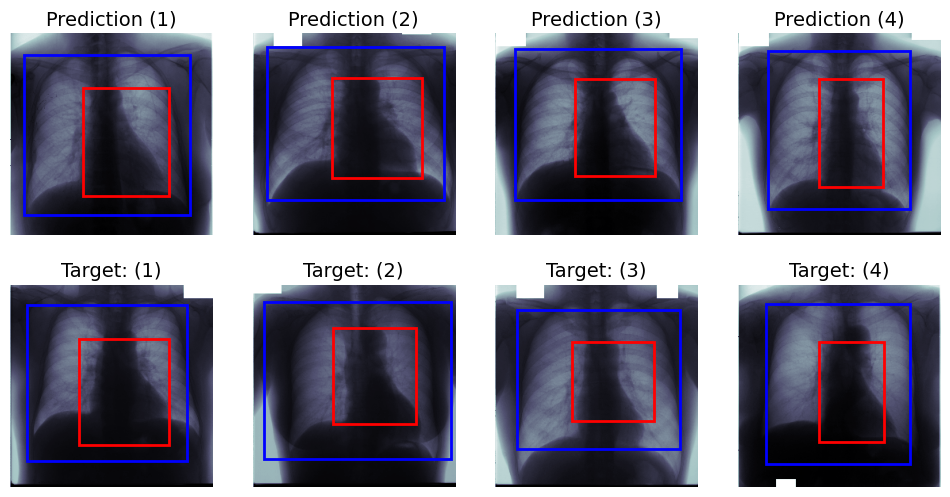

In [25]:
def plot_result(images, op_bboxes, target_bboxes):
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))  # Create a 2x2 grid of subplots
    axs[1, 0].set_title('Targets', fontsize=14, loc='center')
    for idx, ax in zip(range(4), axs[0]):  # Iterate over each subplot
        ax.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
        ax.set_title(f'Prediction ({idx+1})', fontsize=14, loc='center')
        ax.axis('off')
        edge_colors = ["r", "b"]
        for i, box in enumerate(de_normalize_bboxes(op_bboxes[idx])):
            min_x, min_y, max_x, max_y = box
            width = max_x - min_x
            height = max_y - min_y
            rect = patches.Rectangle((min_x, min_y), width, height, linewidth=2, edgecolor=edge_colors[i], facecolor='none')
            ax.add_patch(rect)
        
    for idx, ax in zip(range(4, 8), axs[1]):
        ax.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
        ax.set_title(f'Target: ({idx-3})', fontsize=14, loc='center')
        ax.axis('off')
        edge_colors = ["r", "b"]
        for i, box in enumerate(de_normalize_bboxes(target_bboxes[idx-4])):
            min_x, min_y, max_x, max_y = box
            width = max_x - min_x
            height = max_y - min_y
            rect = patches.Rectangle((min_x, min_y), width, height, linewidth=2, edgecolor=edge_colors[i], facecolor='none')
            ax.add_patch(rect)

    plt.show()
idx=12
plot_result(inputs[:8], outputs[:8], targets[:8])